# Linear Scan versus Priority Grid for Point Lookup

Written by Johannes Kröger (johannes.kroeger(æ)hcu-hamburg(⊙)de, @cartocalypse) based on a lecture and code by Sabine Storandt.

## Before you begin:

### Dependencies
- Python 3.6+ for [f-strings](https://docs.python.org/3/whatsnew/3.6.html#whatsnew36-pep498), rework them into .format() calls if you ain't that modern.
- shapely for visualisation. Strip it out if you don't care for that.
- ipywidgets for interactive widgets. Strip it out if you don't care for that.
- Probably broken if you try to run it in the outdated Python 2 because of integer division and potentially other changes since then.

### Changes to Sabine Storandt's design
While this is in many parts a straight port from C++ to Python, there are some things I changed. Important ones are:

- Switched bbox parameter order from lat/lon to lon/lat aka y/x to x/y because [aaargh](https://macwright.org/lonlat/)...
    - Results in the common Left Bottom Right Top order of values
- Slightly different logic for the point in bbox lookup but same result

### Things to work on if you want
For better code or better performance in no particular order consider:
- Add docstrings for the PriorityGrid class and its methods
- Instead of using a lambda function with sorted(), implement comparison dunder methods for the Point class (eg `__gt__`)
- Why does linearscan sort but then still track the number of points touched?
- Instead of building the grid on the whole globe, divide the data's bbox into grid cells
- If the bbox fully contains some grid cells, we do not have to test the points inside those for containment within the bbox!
- Use a numpy array for the Priority Grid and utilise numpy's fantastic vectorisation if possible!
- Is it possible to find a perfect grid size, at least for a specific dataset? How could you experiment and measure this?

### License
This notebook and its code are distributed under the CC-0: https://creativecommons.org/publicdomain/zero/1.0/

I dedicate the work to the public domain by waiving all my rights to the work worldwide under copyright law, including all related and neighboring rights, to the extent allowed by law.

You can copy, modify, distribute and perform the work, even for commercial purposes, all without asking permission.

## Preparations
First some imports and an option to enable a more verbose mode:

In [1]:
from shapely.geometry import Point, MultiPoint, box, GeometryCollection
from ipywidgets import interact, fixed

In [2]:
verbose = False  # set to True if you want the queries to print information (slower!)

## PriorityPoint class
We want to use points with 2D coordinates and a priority value.
I added `__str__` and `__repr__` implementations so that we can nicely print those points.
The `intersects_bbox` method can be used for testing if a point lies within a bbox (same result as `is_contained` in the original C++ code).

In [3]:
# Using a proper class for the points so we can use methods
class PriorityPoint(object):
    """A PriorityPoint has 2D coordinates x and y as well as a priority value"""
    
    def __init__(self, id, x, y, priority):
        self.id = id
        self.x = x
        self.y = y
        self.priority = priority
        
    def __str__(self):
        return "id: {}, x: {}, y: {}, p: {}".format(self.id, self.x, self.y, self.priority)
        
    def __repr__(self):
        return "PriorityPoint(id={}, x={}, y={}, priority={})".format(
            self.id, self.x, self.y, self.priority)
    
    def __eq__(self, other):
        return self.id == other.id and self.x == other.x \
            and self.y == other.y and self.priority == other.priority
        
    def intersects_bbox(self, bbox):
        """Returns True if point is within or on the edges of the bbox"""
        min_x, min_y, max_x, max_y = bbox
        return min_x <= self.x <= max_x and min_y <= self.y <= max_y
    
assert(PriorityPoint(0,1,2,3) == eval(repr(PriorityPoint(0,1,2,3))))  # TDD? ;)

## Load data
We load the input file and create a PriorityPoint object for each line. They are all saved in a list named `points`.

In [4]:
filename = "cities_all.csv"

# If you run into trouble with the encoding, try to save the input
# file as UTF-8 and then add `encoding="utf-8"` to the open() call
with open(filename) as source:
    source_data = source.readlines()  # read the csv into memory at once!

points = []
for i, entry in enumerate(source_data):
    
    if i == 0:
        continue  # skip the headerline
        
    entry_as_list = entry.strip().split(",")

    lat =    float(entry_as_list[0])
    lon =    float(entry_as_list[1])
    priority = int(entry_as_list[2])  # we use the population as proxy for priority
    
    point = PriorityPoint(i-1, lon, lat, priority)  # i-1 because we skipped the header
    points.append(point)

In [5]:
print(f"{len(points)} points")

145658 points


In [6]:
print("The first 5 points are:")
print("\n".join([str(p) for p in points[:5]]))

The first 5 points are:
id: 0, x: 121.28799, y: 32.4096, p: 0
id: 1, x: 118.84361, y: 26.82139, p: 3150
id: 2, x: 110.10785, y: 26.57584, p: 0
id: 3, x: 108.24972, y: 34.83056, p: 0
id: 4, x: 109.38333, y: 25.23333, p: 0


In [7]:
min_lat = min([p.y for p in points])
max_lat = max([p.y for p in points])
min_lon = min([p.x for p in points])
max_lon = max([p.x for p in points])
min_priority = min([p.priority for p in points])
max_priority = max([p.priority for p in points])

print(f"Bounding Box (LBRT) of all points: {min_lon}, {min_lat}, {max_lon}, {max_lat}")
print(f"Priority values range from {min_priority} to {max_priority}")

Bounding Box (LBRT) of all points: -179.12198, -77.846, 179.36451, 78.22334
Priority values range from 0 to 22315474


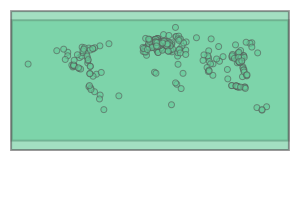

In [8]:
GeometryCollection((
    box(min_lon, min_lat, max_lon, max_lat),
    box(-180,-90,180,90),
    MultiPoint([Point(p.x, p.y) for p in points[::500]])  # sample of just each 500th city
))

## Parameters for the lookup

In [9]:
bbox = (70, -80, 170, 90)
priority = 10000000

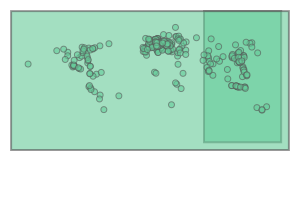

In [10]:
GeometryCollection((
    box(*bbox),
    box(-180,-90,180,90),
    MultiPoint([Point(p.x, p.y) for p in points[::500]])
))

## Linear Scan

In [11]:
def linearscan(points, bbox, min_priority):
    """Returns all points within the bbox with a minimum priority value"""
    
    # input must be sorted by priority, we cannot assume that
    points = sorted(points, key=lambda p: p.priority, reverse=True)  # new list, not sorted in-place    
    
    ids = []
    for i, point in enumerate(points):
        
        # we sorted by priority so we can stop once we get below min_priority
        if point.priority < min_priority:
            if verbose: print(f"... touched {i} points")
            return ids
        
        if point.intersects_bbox(bbox):
            ids.append(point.id)
        
    return ids

In [12]:
%%timeit  # takes about 70ms per run for me, irregardless of printing
result_indices = linearscan(points, bbox, min_priority=priority)

10 loops, best of 3: 70.1 ms per loop


In [13]:
# since %%timeit does not "save" the last run, we need to call it normally again
result_indices = linearscan(points, bbox, min_priority=priority)

In [14]:
result_points = [points[i] for i in result_indices]

In [15]:
print(f"{len(result_indices)} results")
print("The first (upto) 5 resulting points are:")
print("\n".join([str(p) for p in result_points[:5]]))

10 results
The first (upto) 5 resulting points are:
id: 96931, x: 121.45806, y: 31.22222, p: 22315474
id: 89114, x: 72.88261, y: 19.07283, p: 12691836
id: 140721, x: 116.39723, y: 39.9075, p: 11716620
id: 40267, x: 117.17667, y: 39.14222, p: 11090314
id: 188, x: 113.25, y: 23.11667, p: 11071424


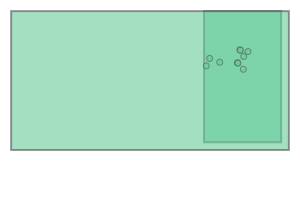

In [16]:
GeometryCollection((
    box(*bbox),
    box(-180,-90,180,90),
    MultiPoint([Point(p.x, p.y) for p in result_points])
))

## Priority Grid

In [17]:
class PriorityGrid(object):
    """TODO"""
    
    def __init__(self, points, dim):
        self.points = points
        self.dim = dim
        
        # the grid is made of rows of cells
        # each cell in the grid has a list of points
        self.grid = [[[] for column in range(dim)] for row in range(dim)]
    
        self.min_x = min([p.x for p in points])
        self.max_x = max([p.x for p in points])
        self.min_y = min([p.y for p in points])
        self.max_y = max([p.y for p in points])
    
        self.delta_x = (self.max_x - self.min_x)/self.dim
        self.delta_y = (self.max_y - self.min_y)/self.dim
        
        # insert points to their cells
        for point in self.points:
            rx = (point.x - self.min_x)/self.delta_x
            row = int(min(rx, self.dim-1))
            
            ry = (point.y - self.min_y)/self.delta_y
            column = int(min(ry, self.dim-1))
            
            cell = self.grid[row][column]
            cell.append(point)
            

        # sort the points within each cell by priority
        for row in self.grid:
            for cell in row:
                cell.sort(key=lambda p: p.priority, reverse=True)  # inplace!
            
    def query_results(self, bbox, min_priority):
        """TODO"""
        
        min_x, min_y, max_x, max_y = bbox

        # make sure that values smaller than the min of the grid are cut off
        min_x = max(min_x, self.min_x)
        min_y = max(min_y, self.min_y)
        # TODO huh, why not also the max?

        # localise the "real" coordinates to the grid cell coordinates
        rx1 = (min_x - self.min_x)/self.delta_x
        x1 = int(min(rx1, self.dim-1))

        ry1 = (min_y - self.min_y)/self.delta_y
        y1 = int(min(ry1, self.dim-1))

        rx2 = (max_x - self.min_x)/self.delta_x
        x2 = int(min(rx2, self.dim-1))

        ry2 = (max_y - self.min_y)/self.delta_y
        y2 = int(min(ry2, self.dim-1))

        ids = []
        if verbose:
            touched_cells = 0
            touched_points = 0
        
        # look for matching points
        for i in range(x1, x2+1):
            for j in range(y1, y2+1):
                if verbose: touched_cells += 1
                cell = self.grid[i][j]
                
                for point in cell:
                    if verbose: touched_points += 1
                    
                    if point.priority < min_priority:
                        break  # proceed to next cell
                    if point.intersects_bbox(bbox):
                        ids.append(point.id)
        if verbose:
            print(f"... touched {touched_cells} of {self.dim*self.dim} cells")
            print(f"... touched {touched_points} points")
        return ids

    def info(self):
        """Prints how many points are in each cell"""
        for i, row in enumerate(pg.grid):
            for j, cell in enumerate(row):
                print(f"{i} {j}: {len(cell)} points")

In [18]:
prioritygrid = PriorityGrid(points, dim=15)

In [19]:
%%timeit  # takes about 25µs per run for me
result_indices = prioritygrid.query_results(bbox, min_priority=priority)
# FIXME this might involve some "unfair" caching according to IPython! Does it really?

10000 loops, best of 3: 25.2 µs per loop


In [20]:
result_indices = prioritygrid.query_results(bbox, min_priority=priority)

In [21]:
result_points = [points[i] for i in result_indices]

In [22]:
print(f"{len(result_indices)} results")
print("The first (upto) 5 resulting points are:")
print("\n".join([str(p) for p in result_points[:5]]))

10 results
The first (upto) 5 resulting points are:
id: 89114, x: 72.88261, y: 19.07283, p: 12691836
id: 58812, x: 77.23149, y: 28.65195, p: 10927986
id: 6601, x: 90.40744, y: 23.7104, p: 10356500
id: 125552, x: 120.9822, y: 14.6042, p: 10444527
id: 188, x: 113.25, y: 23.11667, p: 11071424


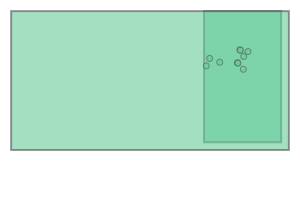

In [23]:
GeometryCollection((
    box(*bbox),
    box(-180,-90,180,90),
    MultiPoint([Point(p.x, p.y) for p in result_points])
))

## Interactive Visualisation

In [24]:
x_range = (-180,180)
y_range = (-90,90)

In [25]:
@interact(
    use_prioritygrid=False,
    prioritygrid=fixed(prioritygrid),
    points=fixed(points), 
    min_x=x_range, min_y=y_range, max_x=x_range, max_y=y_range, 
    priority=(min_priority, max_priority, 100000))
def explore_linearscan(use_prioritygrid, prioritygrid, points, 
                       min_x, min_y, max_x, max_y, priority):
    bbox = min_x, min_y, max_x, max_y
    
    if use_prioritygrid:
        result_indices = prioritygrid.query_results(bbox, min_priority=priority)
    else:
        result_indices = linearscan(points, bbox, priority)
    
    result_points = [points[i] for i in result_indices]
    print(f"{len(result_points)} cities")
    return GeometryCollection((
        box(*bbox),
        box(-180,-90,180,90),
        MultiPoint([Point(p.x, p.y) for p in result_points])
    ))